## Linear Discriminant Analysis from HDFS
In this notebook it is possible to compare the performances of the Linear Discriminant Analysis method over portions of the dataset with different dimensions, taken from the HDFS. This analysis was performed for the following reasons:
1. LDA is not natively implemented in pyspark
2. It is possible to imagine a dataset as a collection divided in partitions in the HDFS
3. It is possible to evaluate the performances of an LDA classifier fitted over an increasing number of concatenated partitions to find a good trade-off between accurate predictions and entries in the training set

In [53]:
import json

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import kds
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType

print("the packages have been imported")

the packages have been imported


In [44]:
spark = SparkSession.builder.master("local[1]").appName("LDA").getOrCreate()

In [54]:
credit_schema = StructType([\
    StructField("ID", IntegerType(), False),
    StructField("LIMIT_BAL", IntegerType(), False),
    StructField("SEX", IntegerType(), False),
    StructField("EDUCATION", IntegerType(), False),
    StructField("MARRIAGE", IntegerType(), False),
    StructField("AGE", IntegerType(), False),
    StructField("PAY_0", IntegerType(), False),
    StructField("PAY_2", IntegerType(), False),
    StructField("PAY_3", IntegerType(), False),
    StructField("PAY_4", IntegerType(), False),
    StructField("PAY_5", IntegerType(), False),
    StructField("PAY_6", IntegerType(), False),
    StructField("BILL_AMT1", IntegerType(), False),
    StructField("BILL_AMT2", IntegerType(), False),
    StructField("BILL_AMT3", IntegerType(), False),
    StructField("BILL_AMT4", IntegerType(), False),
    StructField("BILL_AMT5", IntegerType(), False),
    StructField("BILL_AMT6", IntegerType(), False),
    StructField("PAY_AMT1", IntegerType(), False),
    StructField("PAY_AMT2", IntegerType(), False),
    StructField("PAY_AMT3", IntegerType(), False),
    StructField("PAY_AMT4", IntegerType(), False),
    StructField("PAY_AMT5", IntegerType(), False),
    StructField("PAY_AMT6", IntegerType(), False),
    StructField("default payment next month", IntegerType(), False)])

In [66]:
def serialize_df(df_to_ser, path_where_ser, df_name):
  """
  Function to serialize a pyspark dataframe to json while also saving its schema.

  Params:
    df_to_ser: dataframe to serialize
    path_where_ser: root directory where the files (one json file for the schema
                    and another one for data) will be saved
    df_name: the name of the dataset that must be serialized (it is a string
             that will be added to both json files)
  """
  schema_to_ser = df_to_ser.schema.json()  
  with open(path_where_ser + "%s_schema.json"%df_name, "w") as json_file:
    to_ser = json.dumps(schema_to_ser, indent = 4)
    json_file.write(to_ser)
  df_to_ser.write.json(path_where_ser + "/%s.json"%df_name, mode="overwrite")


def load_df(path_where_ser, df_name):
  """
  Function to load a pyspark dataframe known its schema.

  Params: 
    path_where_ser: root directory of the files of the 
                    serialized dataset and its schema
    df_name: actual name of the df (string that was used to give a name the
             json file)
  Returns:
    to_return: the loaded dataset with the loaded schema
  """
  with open(path_where_ser + "%s_schema.json"%df_name, "r") as json_file:
    json_obj = json.load(json_file)
    loaded_schema = StructType.fromJson(json.loads(json_obj))
  to_return = spark.read.format("json") \
                        .option("header", "true") \
                        .schema(loaded_schema) \
                        .load(path_where_ser + "/%s.json"%df_name)
  return to_return

In [106]:
train_cred = load_df("./serialized/", "train_cred")
test_cred = load_df("./serialized/", "test_cred")

In [39]:
print(train_cred.count())

14328


In [75]:
def split_and_save(train_cred, path, n_partitions):
    """
    Function needed to serialize different splits of the dataset obtained 
    by limiting the original dataset by a fraction of the total number
    of samples. In this way we can obtain the first partition
    that has ((1/n_partitions)*num_samples) samples, the second partition
    that includes the first and has ((2/n_partitions)*num_samples)
    samples, and so on.
    
    Params:
        train_cred: the dataset of which we want to serialize the partitions
                    to the HDFS
        path: the location in the HDFS where the partitions must be saved
        n_partitions: the number of partitions that must be serialized.
    """
    num_samples = train_cred.count()
    splits = []
    length_each_split = num_samples // n_partitions
    for i in range(0, n_partitions): 
      if i == n_partitions - 1:
        partition = train_cred
      else:
        partition = train_cred.limit((i+1)*length_each_split)
      serialize_df(partition, path, "partition_%s"%i)

p_where_save = "./train_partitions/" # the point here is replaced with the
                                     # hdfs root directory
num_partitions = 3
split_and_save(train_cred, p_where_save, num_partitions)

In [81]:
def load_splitted(path, n_partitions):
  """
  Function needed to load the correct partition from the HDFS, 
  this is the complementary function with respect to split_and_save.
  
  Params:
      path: the path in the HDFS from which a partition must be loaded
      n_partitions: integer representing the partition of interest, 
                    i.e. if the dataset was splitted in 3 parts
                    and we consider n_partitions = 2, we will load
                    a dataset containing the first (2/3)*num_samples
                    entries of the whole dataset
  """
  to_conc = []
  for i in range(0, n_partitions):
    df_curr_part = load_df(path, "partition_%s"%i)
    df_curr_part = df_curr_part.toPandas()
    to_conc.append(df_curr_part)
  to_return = np.concatenate(to_conc, axis = 0)
  return to_return

training_partitions = [load_splitted(p_where_save, i) 
                       for i in range(1, num_partitions + 1)]

In [88]:
lda_list = [LinearDiscriminantAnalysis(solver = "svd", tol=0.0001)
               for i in range(0, num_partitions)]
data_X_train_list = [np_data[:, :np_data.shape[1] - 1] 
                             for np_data in training_partitions]
data_y_train_list = [np_data[:, np_data.shape[1] - 1]
                             for np_data in training_partitions]
fitted_lda_list = [lda_list[i].fit(data_X_train_list[i], data_y_train_list[i]) 
                             for i in range(0, num_partitions)]

In [89]:
# extraction of probabilities and predicted labels for the LDA classifier
test_data = test_cred.toPandas().values
data_X = test_data[:, :test_data.shape[1] - 1]
Y_true_lda = test_data[:, test_data.shape[1] - 1]
Y_pred_predictions_lda_list = [fitted_lda.predict(data_X) for fitted_lda
                              in fitted_lda_list]
Y_pred_probs_np_lda_list = [fitted_lda.predict_proba(data_X) for fitted_lda
                              in fitted_lda_list]   

In [90]:
def plot_cumulative_gains_both_classes(y_true, y_probs):
  """
  Function to plot the cumulative gains chart.
  It plots the cumulative number of positive predictions made,
  as function of the total number of positive preditcions

  Params:
    y_true: an array of length num_examples containing the ground truth labels
    y_probs: the probabilities associated for each example
             to each label, it is an array of shape (num_examples, num_classes)  
  """
  skplt.metrics.plot_cumulative_gain(y_true, y_probs)
  plt.xlabel("Number of observations")
  plt.ylabel("Cumulative number of true positive predictions")
  plt.title("Cumulative Gains Chart")
  plt.show()

              precision    recall  f1-score   support

           0       0.81      0.97      0.88     11594
           1       0.69      0.24      0.36      3405

    accuracy                           0.80     14999
   macro avg       0.75      0.60      0.62     14999
weighted avg       0.78      0.80      0.76     14999



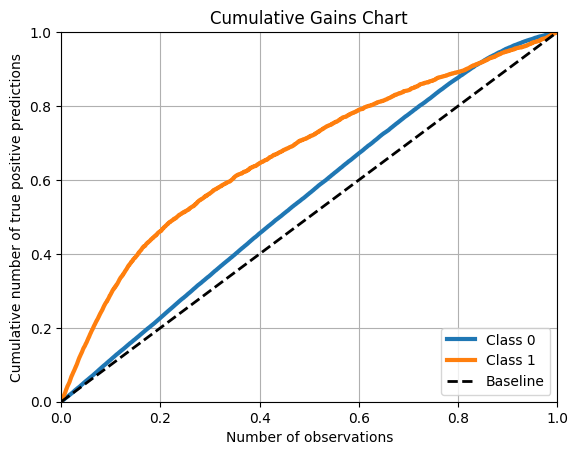

              precision    recall  f1-score   support

           0       0.82      0.96      0.88     11594
           1       0.68      0.27      0.39      3405

    accuracy                           0.81     14999
   macro avg       0.75      0.62      0.64     14999
weighted avg       0.79      0.81      0.77     14999



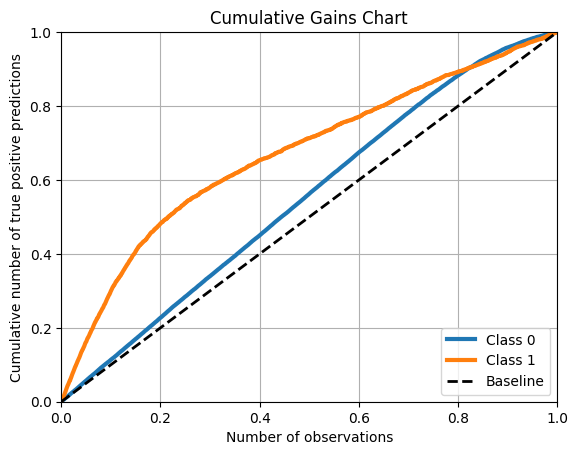

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     11594
           1       0.70      0.27      0.39      3405

    accuracy                           0.81     14999
   macro avg       0.76      0.62      0.64     14999
weighted avg       0.79      0.81      0.77     14999



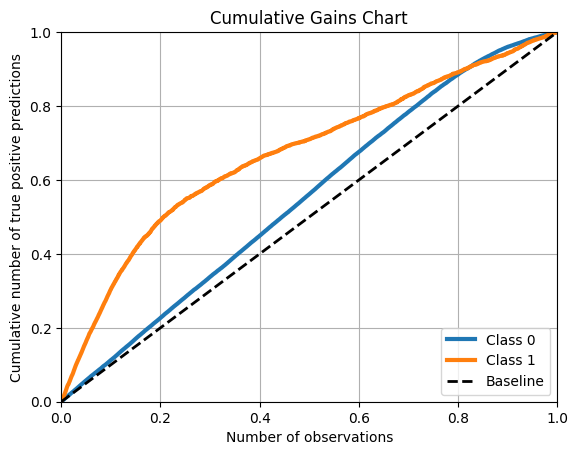

In [91]:
for i in range(0, num_partitions):
    print(classification_report(Y_true_lda, 
                                Y_pred_predictions_lda_list[i]))
    plot_cumulative_gains_both_classes(np.array(Y_true_lda), 
                                       Y_pred_probs_np_lda_list[i])

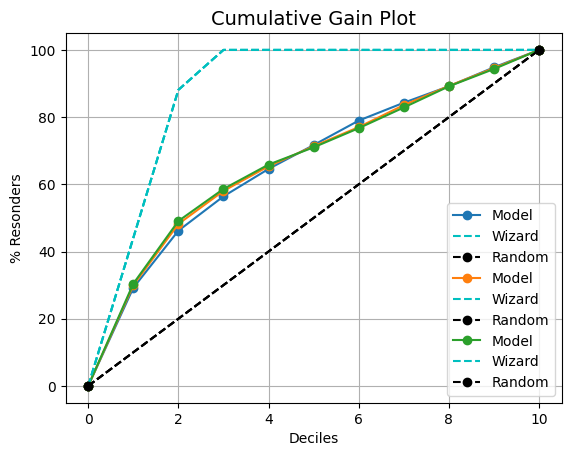

In [93]:
for i in range(0, num_partitions):
    data_y_lda = np.array(Y_true_lda)
    kds.metrics.plot_cumulative_gain(data_y_lda, 
                                     Y_pred_probs_np_lda_list[i][:, 1])

In [94]:
def area_between_curves(curve_1, curve_2):
  """
  Function needed to compute the are between two curves expressed
  as array of floats of the same shape. These arrays contain just the
  y value of each point of the curve.

  Params:
    curve_1: array of floats of which we want to compute the area
             underneath it and subtract from it the area under curve_2
    curve_2: array of floats with the same shape of curve_1, of which
             we want to compute the area underneath it and subtract it
             to the area under curve_2
  Returns:
    difference_between_areas: difference between the
            computed areas below curve_1 and curve_2
  """
  acc_1 = (curve_1[0] / 2)
  acc_2 = (curve_2[0] / 2)
  difference_between_areas = 0
  for i in range(0, len(curve_1) - 1):
    acc_1 += (curve_1[i] + curve_1[i + 1]) / 2
    acc_2 += (curve_2[i] + curve_2[i + 1]) / 2
  difference_between_areas = (acc_1 - acc_2)
  return difference_between_areas

def compute_area_ratio_kds(data_y, Y_pred_probs_np):
  table = kds.metrics.decile_table(data_y, Y_pred_probs_np[:, 1], labels = False) 
  cum_resp_pct = table["cum_resp_pct"]
  cum_resp_pct_rndm = np.arange(10, 110, len(cum_resp_pct))
  cum_resp_pct_wiz = table["cum_resp_pct_wiz"]
  class_rnd_area = area_between_curves(cum_resp_pct, cum_resp_pct_rndm)
  wiz_rnd_area = area_between_curves(cum_resp_pct_wiz, cum_resp_pct_rndm)
  area_ratio =  class_rnd_area / wiz_rnd_area
  return area_ratio

In [99]:
for i in range(0, num_partitions):
    area_ratio_lda = compute_area_ratio_kds(data_y_lda, 
                                            Y_pred_probs_np_lda_list[i])
    print("The area ratio for partition number %s: "%(i+1) + str(area_ratio_lda))

The area ratio for partition number 1: 0.43269686177742755
The area ratio for partition number 2: 0.43799832007096523
The area ratio for partition number 3: 0.43984833537872947


In [100]:
def paper_like_cumulative_gain(true_y, probs_y):
  """
  Function needed to compute the curves (as arrays of floats)
  necessary to plot the cumulative gain chart in the same fashion of 
  the reference paper. In particular we want x_num_samples as the values
  for the x axis and the other three return values as the wizard, classifier
  and baseline curves.

  Params:
    true_y: true labels needed to compute the curves.
    probs_y: probabilities of having 1 as label, computed for each example
             by a classifier.
  Returns:
    classifier_curve: array containing the y values of the classifier curve,
                      it contains the cumulative values of the true labels
                      associated to the sorted array of predictions.
    cum_baseline: array containing the cumulative sum of the value 
                  (#positive_examples / #examples), this represents
                  the baseline classifier.
    best_curve: array containing the cumulative sum of the sorted true labels,
                it represents the best possible classifier.
    x_num_samples: values of the x axis, in particular it ranges from 0 to
                   (num_examples - 1)
  """
  num_examples = true_y.shape[0]
  x_num_samples = np.array([i for i in range(0, num_examples)])
  num_positives = sum(true_y)
  best_curve = np.cumsum(np.sort(true_y)[::-1])
  random_classifier_val = num_positives / num_examples
  baseline = np.array([random_classifier_val for i in range(0, num_examples)])
  cum_baseline = np.cumsum(baseline)
  sorted_idxs = np.argsort(probs_y)[::-1]
  classifier_curve = np.cumsum(np.array([true_y[i] for i in sorted_idxs]))
  return classifier_curve, cum_baseline, best_curve, x_num_samples

def plot_paper_like_gains(classifier_curve, cum_baseline, best_curve, x_num_samples):
  plt.plot(x_num_samples, best_curve, color = "blue")
  plt.plot(x_num_samples, cum_baseline, color = "green")
  plt.plot(x_num_samples, classifier_curve, color = "red")
  plt.show()

def plot_paper_like_gains_and_ratios(data_y, Y_pred_probs_np):
  classifier_curve, cum_baseline, best_curve, x_num_samples = paper_like_cumulative_gain(data_y, Y_pred_probs_np[:, 1])
  class_baseline_area = area_between_curves(classifier_curve, cum_baseline)
  baseline_best_area = area_between_curves(best_curve, cum_baseline)
  area_ratio =  class_baseline_area / baseline_best_area
  plot_paper_like_gains(classifier_curve, cum_baseline, best_curve, x_num_samples)
  print(area_ratio)

Paper-like cumulative gain plot and area ratio for 
          Linear Discriminant Analysis trained on partition 1 is:


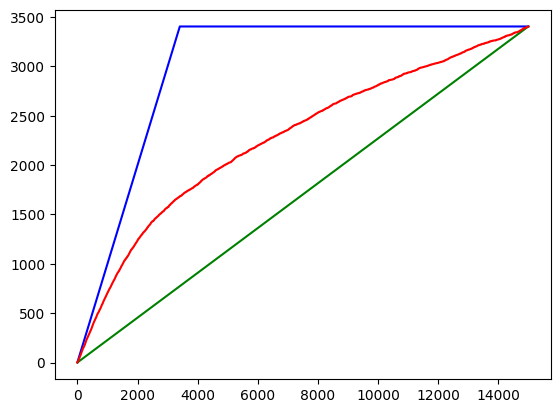

0.4339113577658876
Paper-like cumulative gain plot and area ratio for 
          Linear Discriminant Analysis trained on partition 2 is:


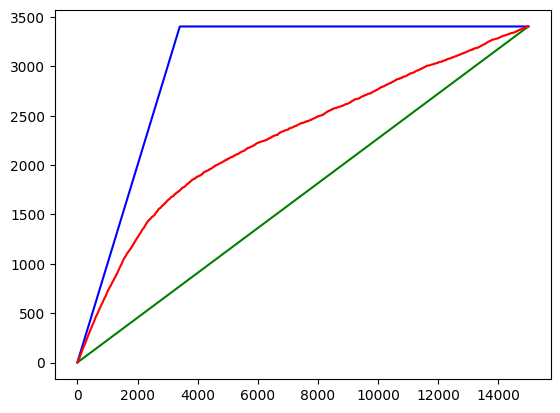

0.43872720636041906
Paper-like cumulative gain plot and area ratio for 
          Linear Discriminant Analysis trained on partition 3 is:


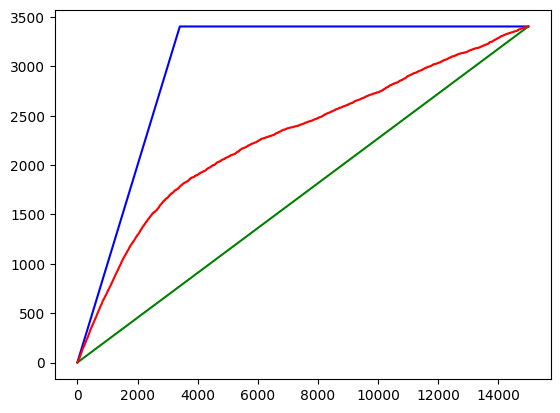

0.4417175119947327


In [103]:
for i in range(0, num_partitions):
    print("""Paper-like cumulative gain plot and area ratio for 
          Linear Discriminant Analysis trained on partition %s is:"""%(i+1))
    plot_paper_like_gains_and_ratios(data_y_lda,
                                     Y_pred_probs_np_lda_list[i])

In [104]:
def sorting_smoothing_method(y_true, y_probs, n_smooth):
  """
  Function needed to estimate the real probability of default as 
  the mean of the n_smooth neighboring labels of a label y_i, where
  a neighbor of y_i (i.e. y_i+1) is the label associated to the 
  i+1 probability value in the sorted array of probabilities computed
  by the classifier. In more simple terms: real probabilities are the mean
  of the (2*n_smooth + 1) true labels ordered according to the sorted y_probs.

  Params: 
    y_true: array of true labels of which we want to estimate 
            the real probabilities
    y_probs: array of probabilities computed by a classifier
    n_smooth: number of smoothing neighbors to consider in order to 
              estimate real probabilities
  Returns: 
    p_vec: estimated real probability values for each true label in y_true
  """
  sort_idx = np.argsort(y_probs[:, 1])
  n_total = y_true.shape[0]
  p_vec = np.zeros(n_total)
  for i in range(0, n_total):
    acc = y_true[sort_idx[i]]
    n_acc = 0
    for n in range(0, n_smooth):
      if i + n < n_total:
        acc += y_true[sort_idx[i + n]]
        n_acc += 1
      if i - n >= 0:
        acc += y_true[sort_idx[i - n]]
        n_acc += 1
    p_vec[i] = acc / n_acc
  return p_vec

def plot_sorting_smoothing_chart(data_y, Y_pred_probs_np):
  p_vec = sorting_smoothing_method(data_y, Y_pred_probs_np, 50)
  ord_probs = np.sort(Y_pred_probs_np[:, 1])

  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ord_probs, p_vec)

  plt.plot(ord_probs, p_vec, 'o', color='blue')
  plt.plot(ord_probs, slope*ord_probs + intercept, color = "red")
  plt.show()

  print("m value: " + str(slope))
  print("q value: " + str(intercept))
  print("r value: " + str(r_value))
  print("r squared: " + str(np.power(r_value, 2)))

Sorting smoothing chart for Linear Discriminant Analysis: 


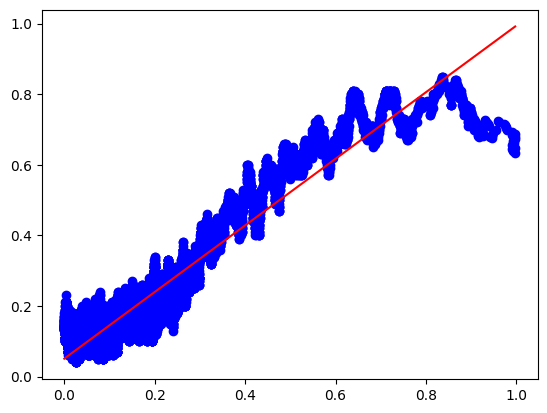

m value: 0.9436109681856123
q value: 0.05083202372914847
r value: 0.942905274941518
r squared: 0.8890703575125396
Sorting smoothing chart for Linear Discriminant Analysis: 


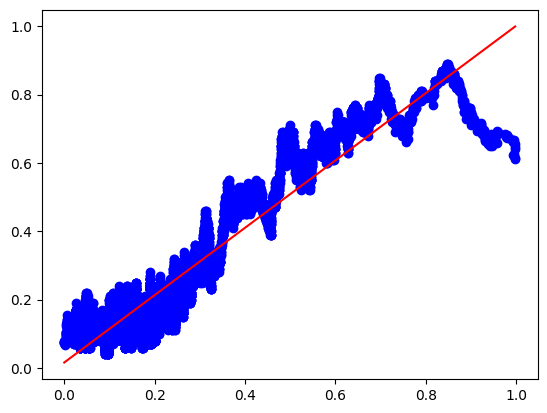

m value: 0.9851526253105959
q value: 0.01623094348484641
r value: 0.9316395044954727
r squared: 0.8679521663365699
Sorting smoothing chart for Linear Discriminant Analysis: 


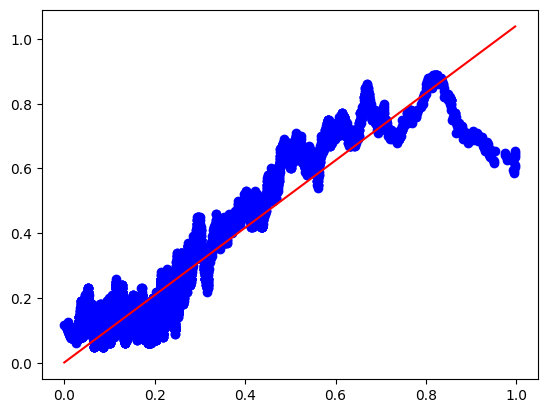

m value: 1.0405895370234877
q value: 0.0007616281414803694
r value: 0.9233310398900292
r squared: 0.8525402092244027


In [105]:
for i in range(0, num_partitions):
    print("Sorting smoothing chart for Linear Discriminant Analysis: ")
    plot_sorting_smoothing_chart(data_y_lda, Y_pred_probs_np_lda_list[i])

In [107]:
spark.stop()